# 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import lineplot

In [2]:
df = pd.read_csv('Data/202107-citibike-tripdata.csv')
df['start_station_id'] = pd.to_numeric(df['start_station_id'], errors='coerce')
df['end_station_id'] = pd.to_numeric(df['end_station_id'], errors='coerce')
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['started_at'] = pd.to_datetime(df['started_at'])
df['duration_mins'] = (df['ended_at'] - df['started_at']).dt.seconds.div(60)
df.dtypes

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id             float64
end_station_name              object
end_station_id               float64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
duration_mins                float64
dtype: object

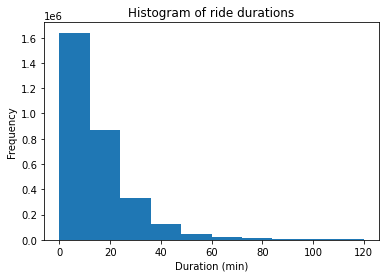

In [3]:
cutoff=120
bins=10
plt.figure()
plt.title('Histogram of ride durations')
plt.ylabel('Frequency')
plt.xlabel('Duration (min)')
plt.hist(df[df['duration_mins'] < cutoff]['duration_mins'], bins=bins)
plt.savefig('Figures/warmup1')

# 2

In [4]:
print("Expected duration:", df['duration_mins'].mean())
print("Duration variance:", df['duration_mins'].var())
print("Probability of ride > 20 mins:", len(df[df['duration_mins'] > 20].index) / len(df.index))

Expected duration: 16.884468517208443
Duration variance: 1055.8471518401905
Probability of ride > 20 mins: 0.24976098519810266


# 3

In [5]:
temp_df = df[df['member_casual'] == 'member']
print("Probability of ride > 20 mins given member:", len(temp_df[temp_df['duration_mins'] > 20].index) / len(temp_df.index))

Probability of ride > 20 mins given member: 0.19422869031097786


# 4

In [6]:
temp_df = df[df['duration_mins'] > 25]
print("Probability of being member given > 25 mins ride:", len(temp_df[temp_df['member_casual'] == 'member'].index) / len(temp_df.index))

Probability of being member given > 25 mins ride: 0.4828903995346324


# Project START
## Drop unwanted columns

In [7]:
df_reduced = df[['ride_id', 'started_at', 'ended_at', 'start_station_id', 'end_station_id']]
df_reduced = df_reduced[(df_reduced['started_at'].dt.weekday != 5) & (df_reduced['started_at'].dt.weekday != 6)]
df_reduced.head()

,ride_id,started_at,ended_at,start_station_id,end_station_id
0,247BA541A9674BF3,2021-07-09 16:05:36,2021-07-09 16:18:09,7372.10,7688.12
2,2E26264BCC15BA05,2021-07-23 06:22:40,2021-07-23 06:36:13,6453.02,5977.01
3,A56D23A088563424,2021-07-05 16:08:10,2021-07-05 16:36:00,7602.05,7161.08
4,1451F4BB884C5335,2021-07-26 12:28:57,2021-07-26 12:30:21,5610.09,5500.07
6,705C67CE4C430371,2021-07-05 15:47:30,2021-07-05 16:12:06,4526.01,4979.07


## Identify Stations to use

In [8]:
df_reduced['start_station_id'].value_counts().head(3)

6140.05    9927
5980.07    9577
5329.03    9545
Name: start_station_id, dtype: int64

In [9]:
df_reduced['end_station_id'].value_counts().head(3)

6140.05    9934
5980.07    9845
5329.03    9506
Name: end_station_id, dtype: int64

### Capacities
Capacities taken from [this Citibike page](https://gbfs.citibikenyc.com/gbfs/fr/station_information.json).
* Station 6140.05 = 50  
* Station 5980.07 = 66  
* Station 5329.03 = 31  

## Break stations up into start and end. Set time column to relevant time. Set values to -1 for leave and +1 for arrive

In [10]:
start_614005 = df_reduced[df_reduced['start_station_id']==6140.05][['ride_id', 'started_at']]
start_614005['start_value'] = -1
start_614005['time'] = start_614005['started_at']

start_598007 = df_reduced[df_reduced['start_station_id']==5980.07][['ride_id', 'started_at']]
start_598007['start_value'] = -1
start_598007['time'] = start_598007['started_at']

start_532903 = df_reduced[df_reduced['start_station_id']==5329.03][['ride_id', 'started_at']]
start_532903['start_value'] = -1
start_532903['time'] = start_532903['started_at']

print('6140.05:', start_614005.shape,
      '5980.07:', start_598007.shape,
      '5329.03:', start_532903.shape)

6140.05: (9927, 4) 5980.07: (9577, 4) 5329.03: (9545, 4)


In [11]:
end_614005 = df_reduced[df_reduced['end_station_id']==6140.05][['ride_id', 'ended_at']]
end_614005['end_value'] = 1
end_614005['time'] = end_614005['ended_at']

end_598007 = df_reduced[df_reduced['end_station_id']==5980.07][['ride_id', 'ended_at']]
end_598007['end_value'] = 1
end_598007['time'] = end_598007['ended_at']

end_532903 = df_reduced[df_reduced['end_station_id']==5329.03][['ride_id', 'ended_at']]
end_532903['end_value'] = 1
end_532903['time'] = end_532903['ended_at']

print('6140.05:', end_614005.shape,
      '5980.07:', end_598007.shape,
      '5329.03:', end_532903.shape)

6140.05: (9934, 4) 5980.07: (9845, 4) 5329.03: (9506, 4)


## Create dataframe with all 5 minute chunks in August

In [12]:
time_step=5

In [13]:
times = pd.DataFrame({'time': pd.date_range('2021-07-01 00:00:00',
                                            '2021-07-30 23:59:59',
                                            freq=str(time_step)+'min')}).set_index('time')
times.shape

(8640, 0)

## Left join times with start and end dataframes to chunk the data

In [14]:
start_chunked_614005 = start_614005.set_index('time').sort_values('time').resample(str(time_step)+'T').sum()
start_chunked_614005 = times.join(start_chunked_614005, on='time').fillna(0)

start_chunked_598007 = start_598007.set_index('time').sort_values('time').resample(str(time_step)+'T').sum()
start_chunked_598007 = times.join(start_chunked_598007, on='time').fillna(0)

start_chunked_532903 = start_532903.set_index('time').sort_values('time').resample(str(time_step)+'T').sum()
start_chunked_532903 = times.join(start_chunked_532903, on='time').fillna(0)

print('6140.05:', start_chunked_614005.shape,
      '5980.07:', start_chunked_598007.shape,
      '5329.03:', start_chunked_532903.shape)

6140.05: (8640, 1) 5980.07: (8640, 1) 5329.03: (8640, 1)


In [15]:
end_chunked_614005 = end_614005.set_index('time').sort_values('time').resample(str(time_step)+'T').sum()
end_chunked_614005 = times.join(end_chunked_614005, on='time').fillna(0)

end_chunked_598007 = end_598007.set_index('time').sort_values('time').resample(str(time_step)+'T').sum()
end_chunked_598007 = times.join(end_chunked_598007, on='time').fillna(0)

end_chunked_532903 = end_532903.set_index('time').sort_values('time').resample(str(time_step)+'T').sum()
end_chunked_532903 = times.join(end_chunked_532903, on='time').fillna(0)

print('6140.05:', end_chunked_614005.shape,
      '5980.07:', end_chunked_598007.shape,
      '5329.03:', end_chunked_532903.shape)

6140.05: (8640, 1) 5980.07: (8640, 1) 5329.03: (8640, 1)


## Add start and end values for each chunk to get net input/output

In [16]:
chunked_614005 = start_chunked_614005.join(end_chunked_614005, on='time')
chunked_614005['total'] = chunked_614005['start_value'] + chunked_614005['end_value']
chunked_614005 = chunked_614005[['total']]

chunked_598007 = start_chunked_598007.join(end_chunked_598007, on='time')
chunked_598007['total'] = chunked_598007['start_value'] + chunked_598007['end_value']
chunked_598007 = chunked_598007[['total']]

chunked_532903 = start_chunked_532903.join(end_chunked_532903, on='time')
chunked_532903['total'] = chunked_532903['start_value'] + chunked_532903['end_value']
chunked_532903 = chunked_532903[['total']]

print('6140.05:', chunked_614005.shape,
      '5980.07:', chunked_598007.shape,
      '5329.03:', chunked_532903.shape)

6140.05: (8640, 1) 5980.07: (8640, 1) 5329.03: (8640, 1)


## Write CSVs

In [17]:
chunked_614005.to_csv('processed_station_614005.csv')
chunked_598007.to_csv('processed_station_598007.csv')
chunked_532903.to_csv('processed_station_532903.csv')

## Sanity plots

<AxesSubplot:xlabel='time'>

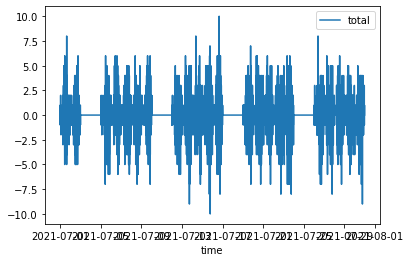

In [18]:
lineplot(data=chunked_614005)

<AxesSubplot:xlabel='time'>

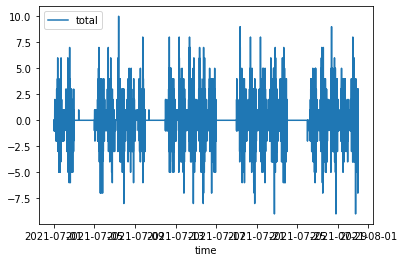

In [19]:
lineplot(data=chunked_598007)

<AxesSubplot:xlabel='time'>

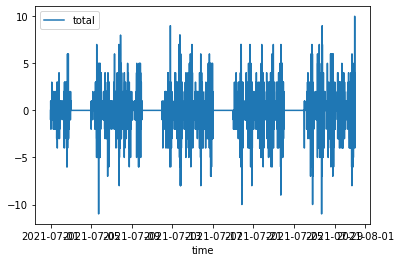

In [20]:
lineplot(data=chunked_532903)

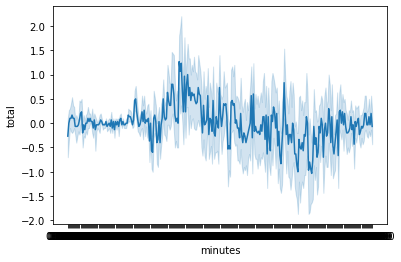

In [21]:
chunked_614005['index_copy'] = chunked_614005.index
chunked_614005['minutes'] = pd.to_datetime(chunked_614005['index_copy']).dt.strftime('%H:%M:%S')
lineplot(y='total', x='minutes', data=chunked_614005);

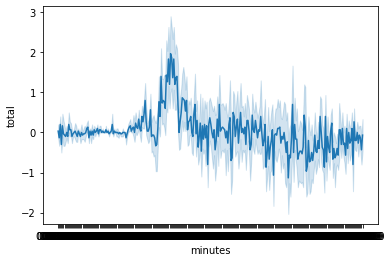

In [22]:
chunked_598007['index_copy'] = chunked_598007.index
chunked_598007['minutes'] = pd.to_datetime(chunked_598007['index_copy']).dt.strftime('%H:%M:%S')
lineplot(y='total', x='minutes', data=chunked_598007);

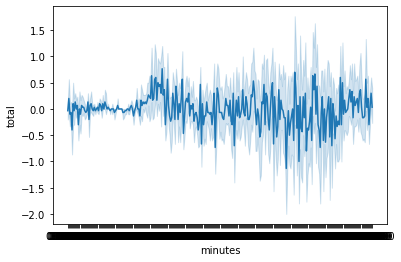

In [23]:
chunked_532903['index_copy'] = chunked_532903.index
chunked_532903['minutes'] = pd.to_datetime(chunked_532903['index_copy']).dt.strftime('%H:%M:%S')
lineplot(y='total', x='minutes', data=chunked_532903);